### Preparation
- Import package
- Load functions needed later

In [ ]:
# Google Colab mount - commented out for local use
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datetime import datetime, timedelta
import re
from PIL import Image
import numpy as np
from collections import defaultdict, OrderedDict
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def parse_date(item):
  """
  Convert a string in the format "Jan 2023" to a datetime object.
  """
  return datetime.strptime(item, "%b %Y")

def is_on_or_after(target, reference="1855-10"):

  # Convert strings to datetime objects
  target_date = datetime.strptime(target, "%b %Y")
  reference_date = datetime.strptime(reference, "%Y-%m")

  # Compare dates
  return target_date >= reference_date

# change the working directory to the repository root
# Assuming the notebook is in the src folder
os.chdir(os.path.join(os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd(), '..'))

### Data Collection
- Fetch files, count pixels, prepare structured data for visualization.

#### Group 1 (current group) data processing

In [33]:
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1Pujk9ZCmW5OfzzRPjgiA5OalE7Egg5Yy/Data


In [4]:

filelist= glob.glob('Group1/*') # get every file under the folder names Group1
png_g1 = [f for f in filelist if f.endswith('.png')] # Filter the png files from all files under Group1

print(len(png_g1))

58


In [5]:
unformatted_data = []
data_dict = defaultdict(list) # defaultdict would avoid key errors, by creating new key if when a not exsit key is called.

# this dictionary can be converted to a pandas dataframe directly. It would, then, be easily saved as CSV file.
result = {
    'Month': [],
    'wound': [],
    'disease': [],
    'other': []
}

for img_path in png_g1: # Get a individual wedge.
  png_name = img_path.lower().split('/',1)[-1]

  # extract time, and category name from the file name, and then save to variables.
  time, field_name = re.search(r'(\d{4}-\d*)_(.*).png', png_name).groups()
  # Convert str to datatime, then back to str. it will looks like Jan 2024
  mon_year = datetime.strptime(time, "%Y-%m").strftime("%b %Y")

  # Convert image to NumPy array
  img_rgb = np.array(Image.open(img_path))

  # Extract the alpha channel (4th channel in RGBA) from the image
  # [row, columns, rgba]
  alpha_channel = img_rgb[:, :, 3]

  # Count transparent pixels (where alpha is 0 -- when alpha is zero, it is transperant)
  if not is_on_or_after(mon_year):
    # print(f"{mon_year} is before 1855-10")
    pixel_count = np.sum(alpha_channel == 0)
  else:
    # because the group member make the wanted part not trasparent (which is inversed from what is expected...)
    # print(f"{mon_year} is after or in 1855-10")
    pixel_count = np.sum(alpha_channel != 0)

  # save the data to pre made variable unformatted_data which is a list
  unformatted_data.append((mon_year, field_name, pixel_count))


# Sorting the data by date
sorted_data = sorted(unformatted_data, key=lambda date: parse_date(date[0]))

# This is a dictionary with mon-year as key, and all corresponding (category, value) tuples
for entry in sorted_data:
  data_dict[entry[0]].append((entry[1], entry[2]))

# Fill result dictionary.
for month_y, list_of_pair in data_dict.items():
  result['Month'].append(month_y)
  # Creating a temparory dictionary, so that get() method can be used to avoid if statement.
  temp_dict = dict(list_of_pair)
  # For some month, mortality count under certain cetagory might not be avaliable.
  # The code below would check if the count if avaliable, if not, assign 0 as value.
  result['disease'].append(temp_dict.get('disease', 0))
  result['other'].append(temp_dict.get('other', 0))
  result['wound'].append(temp_dict.get('wound', 0))

# Print the structure data for validation (making sure each category has 24 values --> 2 year = 24 month)
print(len(result['disease']))
print(len(result['wound']))
print(len(result['other']))
print(len(result['Month']))
print(result)

24
24
24
24
{'Month': ['Apr 1854', 'May 1854', 'Jun 1854', 'Jul 1854', 'Aug 1854', 'Sep 1854', 'Oct 1854', 'Nov 1854', 'Dec 1854', 'Jan 1855', 'Feb 1855', 'Mar 1855', 'Apr 1855', 'May 1855', 'Jun 1855', 'Jul 1855', 'Aug 1855', 'Sep 1855', 'Oct 1855', 'Nov 1855', 'Dec 1855', 'Jan 1856', 'Feb 1856', 'Mar 1856'], 'wound': [0, 0, 0, 0, 0, 1429, 3107, 6683, 2904, 1531, 1172, 820, 0, 437, 3613, 1447, 2220, 1777, 377, 348, 107, 0, 0, 0], 'disease': [0, 173, 222, 10008, 22541, 19759, 9318, 17282, 41078, 75447, 45638, 29622, 11684, 10846, 12487, 4830, 6414, 2714, 1995, 3283, 1435, 0, 0, 402], 'other': [447, 264, 40, 711, 887, 500, 0, 0, 534, 5299, 7260, 3733, 1215, 802, 732, 637, 469, 374, 257, 372, 638, 965, 443, 396]}


### Data visualization
- Write data to csv for reuse
- Historical recreation (Polar bar chart)
- Area chart and line plot
- Stacked bar chart

In [ ]:
# convert structured data to pandas dataframe, save as csv then read it back
# df = pd.DataFrame(result)
# df.to_csv('data/result.csv', index=False)
df = pd.read_csv('data/result.csv')

#### Polar bar chart

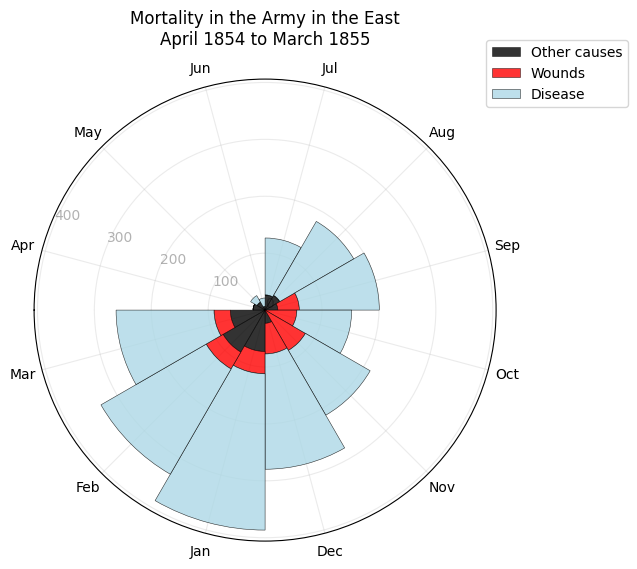

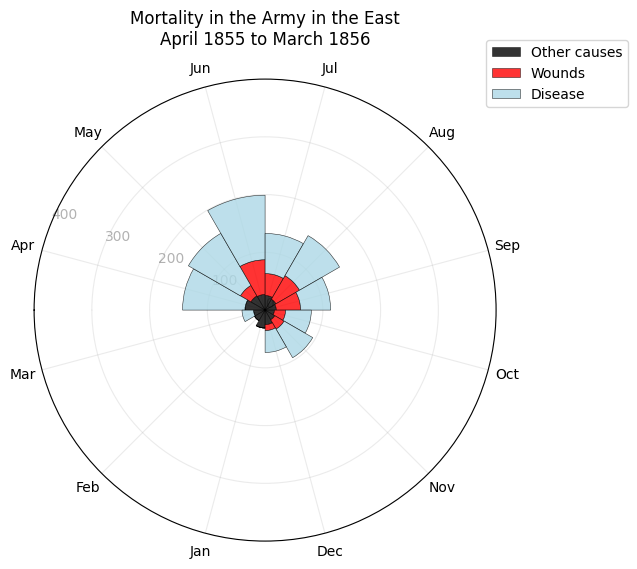

In [ ]:

def create_nightingale_rose(data, title):
    # Convert data to DataFrame
    # df = pd.DataFrame(data)
    df = data

    # Set up the plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='polar')

    # Calculate angles for each month (in radians)
    n_months = len(df)
    angles = np.linspace(0, 2*np.pi, n_months, endpoint=False)

    # creating an array that would be use as y axis value (0 ~ 400)
    y_axis_value = np.linspace(0,400,5)

    # Plot each cause of death
    width = 2*np.pi / n_months

    # Get the radii
    # With area being pixel count,
    # the propotion of the radii can be represent by the square root of the area (constants would affect the propotion)
    radii_other = np.sqrt(df['other'])
    radii_wound = np.sqrt(df['wound'])
    radii_disease = np.sqrt(df['disease'])

    # minor rotation adjustment, so that it would match the original plot exactly.
    rotation_angle = np.pi/12
    # rotation_angle =0


    # Plot in reverse order so disease (largest) is on top
    ax.bar(angles+rotation_angle, radii_other, width=width, bottom=0.0,
           color='black', alpha=0.8, label='Other causes',edgecolor='black', zorder=2, linewidth = 0.4)

    ax.bar(angles+rotation_angle, radii_wound, width=width, bottom=radii_other,
           color='red', alpha=0.8, label='Wounds',edgecolor='black', zorder=2, linewidth = 0.4)

    # The addition of the 'bottom' parameter is making sure that the wedges are stacked.
    ax.bar(angles+rotation_angle, radii_disease, width=width, bottom=radii_other + radii_wound,
           color='lightblue', alpha=0.8, label='Disease', edgecolor='black',zorder=2, linewidth = 0.4)


    # Customize the plot
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_theta_zero_location('W')  # make the zero degree (labeled apr to the left)

    # Set month labels
    month_labels = [date.split(' ')[0][:3] for date in df['Month']] # get month abbr for label
    ax.set_xticks(angles+rotation_angle) # set  xtick location
    ax.set_xticklabels(month_labels) # set xtick value

    ax.set_yticks(y_axis_value)
    # ax.set_yticklabels([])

    # adjust the transperancy of the grid.
    ax.grid(alpha=0.25)

    # Add title and legend
    plt.title(title, pad=25)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.setp(ax.get_yticklabels(), alpha=0.3)

    return fig


# Create two separate plots for the two time periods
# first_year = {key: value[:12] for key, value in result.items()}
# second_year = {key: value[12:] for key, value in result.items()}

first_year = df[:12]
second_year = df[12:]

# Generate plots
fig1 = create_nightingale_rose(first_year, 'Mortality in the Army in the East\nApril 1854 to March 1855')
fig1.savefig('output/nightingale_rose_1854-1855.png', dpi=300, bbox_inches='tight')

fig2 = create_nightingale_rose(second_year, 'Mortality in the Army in the East\nApril 1855 to March 1856')
fig2.savefig('output/nightingale_rose_1855-1856.png', dpi=300, bbox_inches='tight')

plt.show()

#### Area charts and line plots

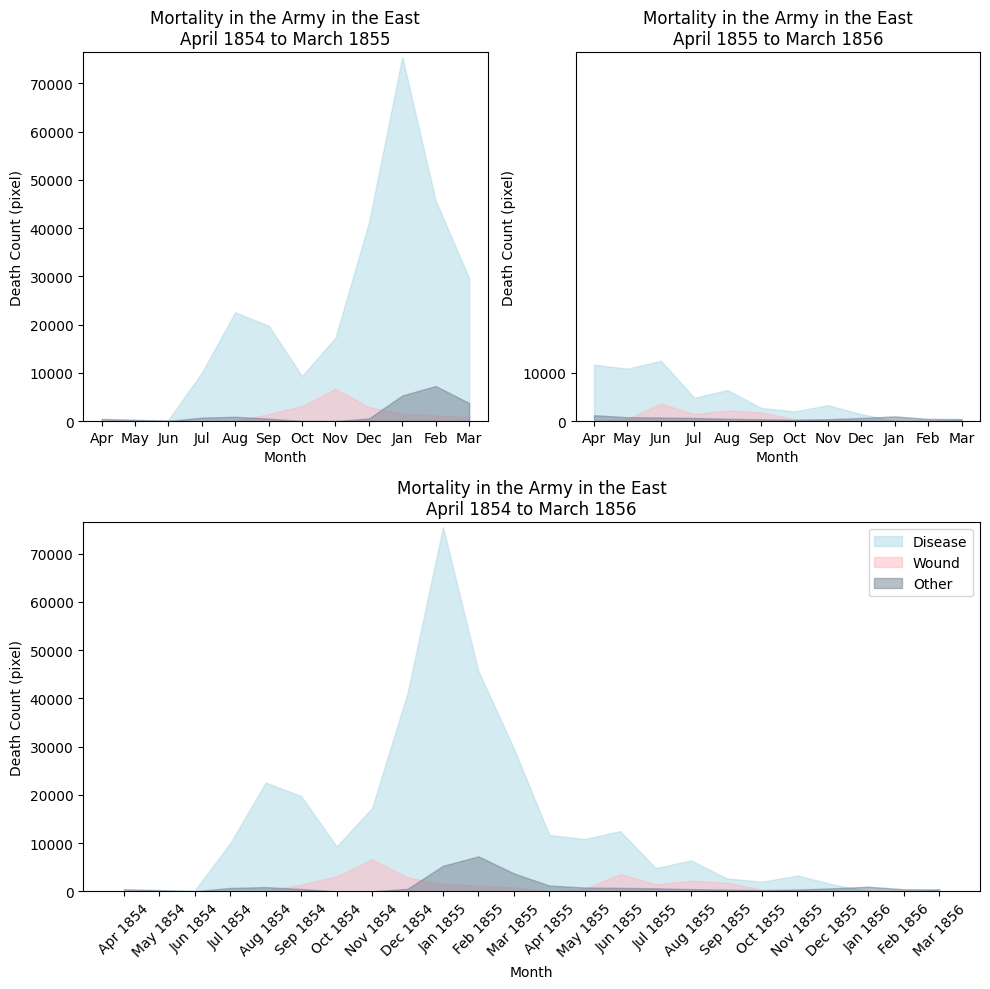

In [ ]:
# df = pd.DataFrame(result)
df = pd.read_csv('data/result.csv')

# configure the layout, data, and title for subplots.
subplot_configs = [
    (2, 2, 1, df[:12], "Mortality in the Army in the East\nApril 1854 to March 1855"),
    (2, 2, 2, df[12:], "Mortality in the Army in the East\nApril 1855 to March 1856"),
    (2, 2, (3, 4), df, "Mortality in the Army in the East\nApril 1854 to March 1856")
]

plt.figure(figsize=(10, 10))

for rows, cols, index, data, title in subplot_configs:
    x_value = np.array([i.split(' ')[0][:3] for i in data['Month']]) # Get Month abbr for x axis

    plt.subplot(rows, cols, index) # create subplots given configurations.

    # create 3 area charts with transperancy.
    plt.fill_between(np.arange(len(data['Month'])), data['disease'],
                 color="lightblue", alpha=0.5, label='Disease')
    plt.fill_between(data['Month'], data['wound'],
                    color="lightpink", alpha=0.5, label='Wound')
    plt.fill_between(data['Month'], data['other'],
                    color="slategrey", alpha=0.5, label='Other')

    if not isinstance(index, int): # if the is the whole year plot, the add year to the x ticks label. then rotate 45 degree.
      plt.xticks(np.arange(len(data['Month'])), data['Month'], rotation=45)
    else:
      plt.xticks(np.arange(len(data['Month'])), x_value)

    plt.xlabel('Month')
    plt.yticks(np.arange(0, max(data['disease'])+1000,10000)) # set up ytick places by array
    plt.ylabel('Death Count (pixel)')
    plt.ylim(0, max(df['disease'])+1000)  # give the max and min for y axis, so that the scale is consistent b/w plots.
    plt.title(title)

plt.tight_layout()
plt.legend()
plt.savefig('output/area_charts.png', dpi=300, bbox_inches='tight')
plt.show()

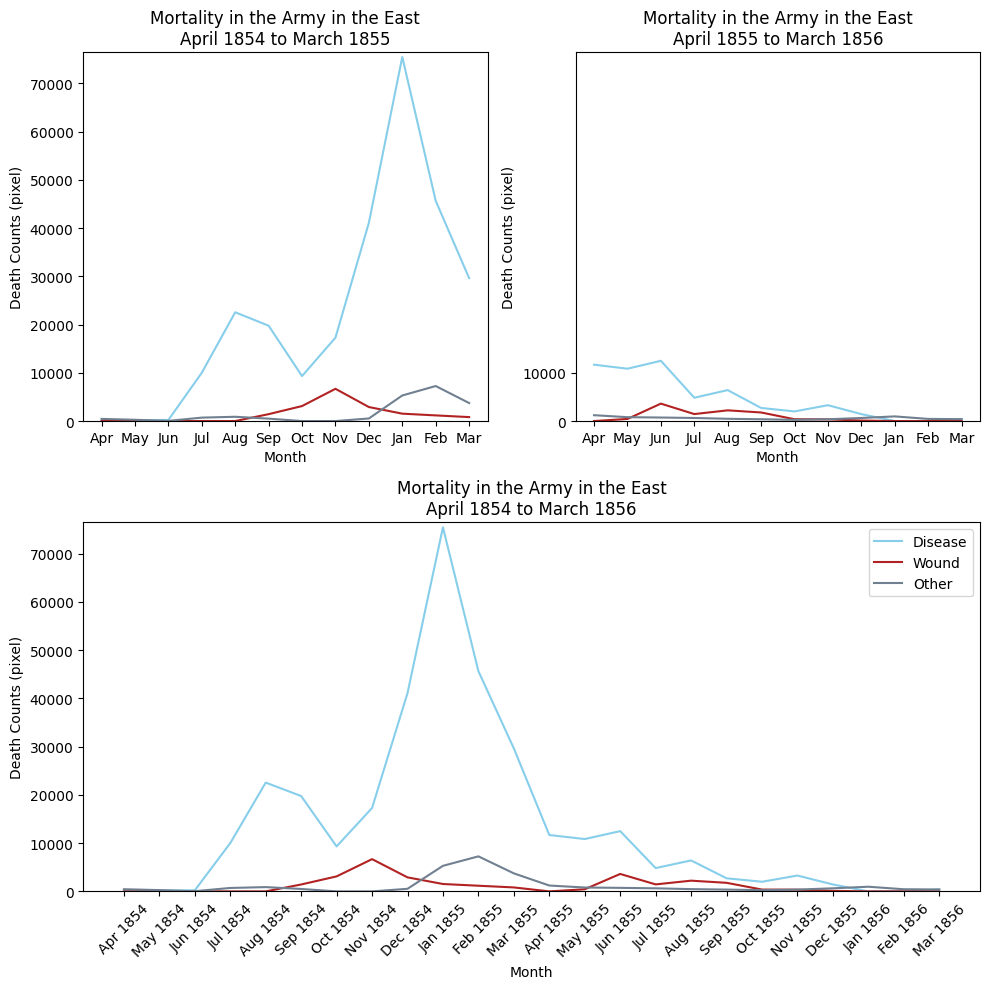

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Comments refer to area chart code

# df = pd.DataFrame(result)
df = pd.read_csv('data/result.csv')

subplot_configs = [
    (2, 2, 1, df[:12], "Mortality in the Army in the East\nApril 1854 to March 1855"),
    (2, 2, 2, df[12:], "Mortality in the Army in the East\nApril 1855 to March 1856"),
    (2, 2, (3, 4), df, "Mortality in the Army in the East\nApril 1854 to March 1856")
]

plt.figure(figsize=(10, 10))

for rows, cols, index, data, title in subplot_configs:
    x_value = np.array([i.split(' ')[0][:3] for i in data['Month']])

    plt.subplot(rows, cols, index)
    plt.plot(np.arange(len(data['Month'])), data['disease'],
                 color="skyblue", label='Disease')
    plt.plot(data['Month'], data['wound'],
                    color="firebrick", label='Wound')
    plt.plot(data['Month'], data['other'],
                    color="slategrey", label='Other')

    if not isinstance(index, int):
      plt.xticks(np.arange(len(data['Month'])), data['Month'], rotation=45)
    else:
      plt.xticks(np.arange(len(data['Month'])), x_value)

    plt.xlabel('Month')
    plt.yticks(np.arange(0, max(data['disease'])+1000,10000))
    plt.ylabel('Death Counts (pixel)')
    plt.ylim(0, max(df['disease'])+1000)  # Adjust y-axis if needed
    plt.title(title)

plt.tight_layout()
plt.legend()
plt.savefig('output/line_plots.png', dpi=300, bbox_inches='tight')
plt.show()

#### Stacked bar chart

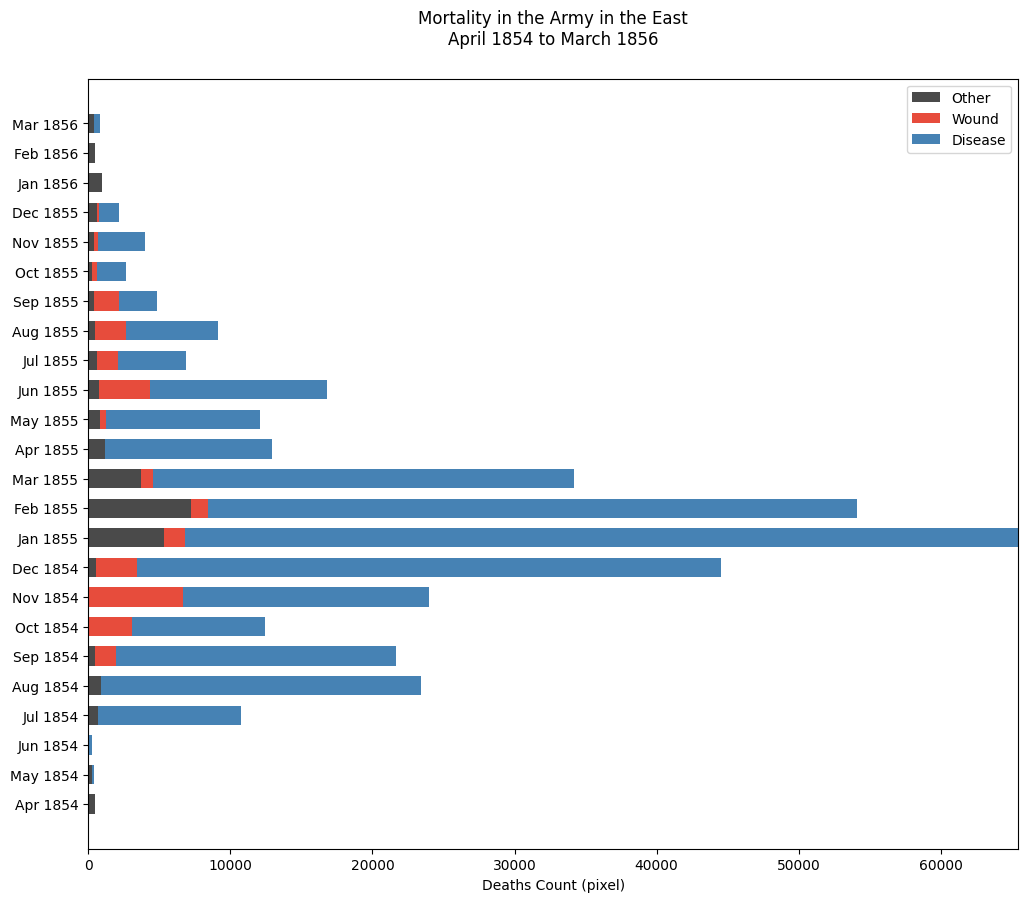

In [ ]:
df = pd.read_csv('data/result.csv')

# the width of the bars: can also be len(x) sequence
width = 0.65

fig, ax = plt.subplots(figsize=(12,10))

# create horizontal bars with 2 year data.
# The left parameter is to configured so that the bars are stacked.
ax.barh(df['Month'], df['other'], width, label='Other', color='#4A4A4A')
ax.barh(df['Month'], df['wound'], width, left=df['other'], label='Wound', color='#E74C3C')
ax.barh(df['Month'], df['disease'], width, left=df['other'] + df['wound'], label='Disease', color='#4682B4')

# The big contrast between month is too large, leading to the month with small counts can't be seen.
# To solve the problem, I cut the x axis by 10000 to hide the longer part of some bars.
ax.set_xlim(0, max(df[:12]['disease'])-10000)
ax.set_xlabel('Deaths Count (pixel)')

ax.set_title('Mortality in the Army in the East\nApril 1854 to March 1856', pad=25)

ax.legend()

plt.savefig('output/stacked_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()